In [28]:
import numpy as np
from matplotlib import pyplot as plt
import pystan

In [29]:
np.float64

numpy.float64

In [30]:
#Just a set rgb colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

In [31]:
N = 1
I0 = 0.01
R0 = 0
S0 = (N - I0 - R0)
S = [S0]*100
R = [0]*100
I = [I0]*100
# S2 = S1[:]
# R2 = R1[:]
# I2 = I1[:]
# S3 = S1[:]
# R3 = R1[:]
# I3 = I1[:]
gamma_mu = 0.1
beta_mu = 0.6

# Gamma distribution
$$p(x) = x^{k-1}\frac{e^{-x/\theta}}{\theta^k\Gamma(k)},$$
$$k = \frac{\mu^2}{\sigma^2}$$
$$\theta = \frac{\sigma^2}{\mu} = \frac{\mu}{k}$$

# Beta distribution
$$p(x) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)}$$
$$\alpha = \frac{\mu(1-\mu)-\sigma^{2}}{\sigma^{2}\Big(1+\frac{\sigma^{2}(1-\mu)}{\mu}\Big)}$$
$$\beta = \frac{\alpha(1-\mu)}{\mu}$$

In [32]:
# mu = beta_mu
# sigma2 = np.square(beta/3)
# a = (mu*(1-mu) - sigma2)/(sigma2*(1+((sigma2*(1-mu))/mu)))
# b = a*(1-mu)/mu
# beta = np.random.beta(a, b, 100)
# beta

In [33]:
mu = beta_mu
sigma2 = np.square(mu/2 + mu/6 + mu/24 + mu/120 + mu/720)
# sigma2 = np.square(mu/2)
k = np.square(mu/sigma2)
shape = k
scale = mu/k
beta = np.random.gamma(shape, scale, 100000).reshape(1000, 100)

In [34]:
mu = gamma_mu
# sigma2 = np.square(mu/2 + mu/3 + mu/4)
sigma2 = np.square(mu + mu/2 + mu/6 + mu/24 + mu/120)
k = np.square(mu/sigma2)
shape = k
scale = mu/k
gamma = np.random.gamma(shape, scale, 100000).reshape(1000, 100)
gamma

array([[0.12090726, 0.07589471, 0.0971964 , ..., 0.04886466, 0.11732827,
        0.14332718],
       [0.0659265 , 0.09086053, 0.10268971, ..., 0.14489368, 0.10723888,
        0.12713064],
       [0.06561911, 0.11166194, 0.14556423, ..., 0.10275863, 0.12955046,
        0.10760316],
       ...,
       [0.08995829, 0.07684461, 0.09334369, ..., 0.09367236, 0.10075393,
        0.08360315],
       [0.10236346, 0.08263949, 0.1363062 , ..., 0.125627  , 0.10924092,
        0.08943109],
       [0.09566107, 0.07087133, 0.10359616, ..., 0.09493159, 0.07742087,
        0.14036837]])

In [35]:
def r(R, beta, gamma):
    R0 = beta/gamma
    return gamma*(N - R - S0*(np.e**(-R0*R)))

# Alternative SIR formulation (Butcher's solver)

In [36]:
def A_SIR_Butcher_r(R, h, beta, gamma):
    for i in range(1, 100):
        k1 = r(R[i-1], beta[i], gamma[i])
        k2 = r(R[i-1] + (1/4)*k1*h, beta[i], gamma[i])
        k3 = r(R[i-1] + (1/8)*k1*h + (1/8)*k2*h, beta[i], gamma[i])
        k4 = r(R[i-1] - (1/2)*k2*h + k3*h, beta[i], gamma[i])
        k5 = r(R[i-1] + (3/16)*k3*h + (9/16)*k4*h, beta[i], gamma[i])
        k6 = r(R[i-1] - (3/7)*k1*h + (2/7)*k2*h + (12/7)*k3*h - (12/7)*k4*h + (8/7)*k5*h, beta[i], gamma[i])
        R[i] = R[i-1] + (1/90)*((7*k1) + (32 * k3) + (12 * k4) + (32 * k5) + (7*k6))*h
    return R

In [37]:
def A_SIR_Butcher(R, h, beta, gamma):
    for i in range(1, 100):
        k1 = r(R[i-1], beta, gamma)
        k2 = r(R[i-1] + (1/4)*k1*h, beta, gamma)
        k3 = r(R[i-1] + (1/8)*k1*h + (1/8)*k2*h, beta, gamma)
        k4 = r(R[i-1] - (1/2)*k2*h + k3*h, beta, gamma)
        k5 = r(R[i-1] + (3/16)*k3*h + (9/16)*k4*h, beta, gamma)
        k6 = r(R[i-1] - (3/7)*k1*h + (2/7)*k2*h + (12/7)*k3*h - (12/7)*k4*h + (8/7)*k5*h, beta, gamma)
        R[i] = R[i-1] + (1/90)*((7*k1) + (32 * k3) + (12 * k4) + (32 * k5) + (7*k6))*h
    return R

In [38]:
def dS(S, I, beta):
    return -beta*S*I

def dI(S, I, beta, gamma):
    return -dS(I, S, beta) - gamma*I

# SIR formulation (Butcher's solver)

In [39]:
def SIR_Butcher(S, I, h, beta, gamma):
    for i in range(99):
        k11 = dS(S[i], I[i], beta)
        k12 = dI(S[i], I[i], beta, gamma)

        k21 = dS(S[i] + (1/4)*k11*h, I[i] + (1/4)*k12*h, beta)
        k22 = dI(S[i] + (1/4)*k11*h, I[i] + (1/4)*k12*h, beta, gamma)

        k31 = dS(S[i] + (1/8)*k11*h + (1/8)*k21*h, I[i] + (1/8)*k12*h + (1/8)*k22*h, beta)
        k32 = dI(S[i] + (1/8)*k11*h + (1/8)*k21*h, I[i] + (1/8)*k12*h + (1/8)*k22*h, beta, gamma)

        k41 = dS(S[i] - (1/2)*k21*h + k31*h, I[i] - (1/2)*k22*h + k32*h, beta)
        k42 = dI(S[i] - (1/2)*k21*h + k31*h, I[i] - (1/2)*k22*h + k32*h, beta, gamma)

        k51 = dS(S[i] + (3/16)*k31*h + (9/16)*k41*h, I[i] + (3/16)*k32*h + (9/16)*k42*h, beta)
        k52 = dI(S[i] + (3/16)*k31*h + (9/16)*k41*h, I[i] + (3/16)*k32*h + (9/16)*k42*h, beta, gamma)

        k61 = dS(S[i] - (3/7)*k11*h + (2/7)*k21*h + (12/7)*k31*h - (12/7)*k41*h + (8/7)*k51*h, 
                 I[i] - (3/7)*k12*h + (2/7)*k22*h + (12/7)*k32*h - (12/7)*k42*h + (8/7)*k52*h, beta)
        k62 = dI(S[i] - (3/7)*k11*h + (2/7)*k21*h + (12/7)*k31*h - (12/7)*k41*h + (8/7)*k51*h,
                 I[i] - (3/7)*k12*h + (2/7)*k22*h + (12/7)*k32*h - (12/7)*k42*h + (8/7)*k52*h, beta, gamma)    

        S[i+1] = S[i] + (1/90)*((7*k11) + (32 * k31) + (12 * k41) + (32 * k51) + (7*k61))*h
        I[i+1] = I[i] + (1/90)*((7*k12) + (32 * k32) + (12 * k42) + (32 * k52) + (7*k62))*h
    return S, I

# SIR formulation (Ruge-Kutta solver)

In [40]:
def SIR_RK(S, I, h, beta, gamma):
    for i in range(99):
        k11 = dS(S[i], I[i], beta)
        k12 = dI(S[i], I[i], beta, gamma)
        k21 = dS(S[i] + (1/2)*k11*h, I[i] + (1/2)*k12*h, beta)
        k22 = dI(S[i] + (1/2)*k11*h, I[i] + (1/2)*k12*h, beta, gamma)
        k31 = dS(S[i] + (1/2)*k21*h, I[i] + (1/2)*k22*h, beta)
        k32 = dI(S[i] + (1/2)*k21*h, I[i] + (1/2)*k22*h, beta, gamma)
        k41 = dS(S[i] + k31*h, I[i] + k32*h, beta)
        k42 = dI(S[i] + k31*h, I[i] + k32*h, beta, gamma)
        S[i+1] = S[i] + (1/6)*((k11) + (2 * (k21 + k31)) + k41)*h
        I[i+1] = I[i] + (1/6)*((k12) + (2 * (k22 + k32)) + k42)*h
    return S, I

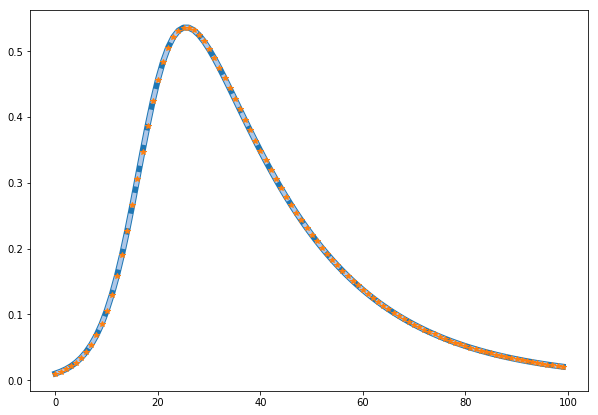

In [41]:
plt.figure(figsize=(10,7))
plt.plot(list(range(100)), N - np.array(A_SIR_Butcher(R, 0.5, beta_mu, gamma_mu)) - S0*np.exp(-beta_mu/gamma_mu*np.array(A_SIR_Butcher(R, 0.5, beta_mu, gamma_mu))), color=tableau20[0], linewidth=6)
plt.plot(list(range(100)), SIR_Butcher(S, I, 0.5, beta_mu, gamma_mu)[1], '--', color=tableau20[1], linewidth=4)
plt.plot(list(range(100)), SIR_RK(S, I, 0.5, beta_mu, gamma_mu)[1], '*', color=tableau20[2])
plt.savefig("test.png")

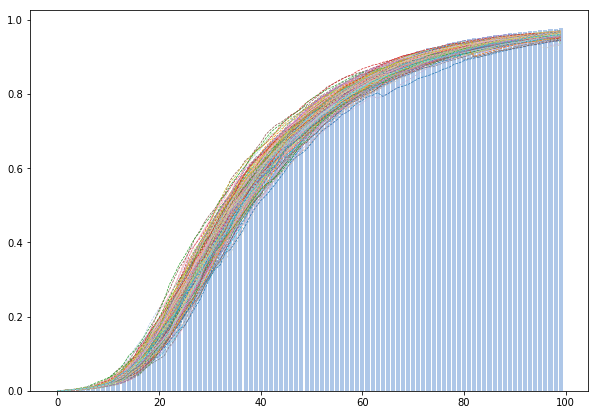

In [42]:
plt.figure(figsize=(10,7))
plt.bar(list(range(100)), np.array(A_SIR_Butcher(R, 0.5, beta_mu, gamma_mu)), color=tableau20[1])
for i in range(200):
#     plt.bar(list(range(100)), np.array(A_SIR_Butcher(R, 0.5, beta_mu, gamma_mu)), color=tableau20[1])
    plt.plot(list(range(100)), np.array(A_SIR_Butcher_r(R, 0.5, beta[i], gamma[i])), '--', color=tableau20[i%20], linewidth=0.7)
plt.savefig("R_randb.png")

In [43]:
drdt = np.array(A_SIR_Butcher_r(R, 0.5, beta[0], gamma[0]))

$$\frac{dR}{dt} = \gamma(N - R - S_{0}e^{-\mathfrak{R}_{0}R})$$

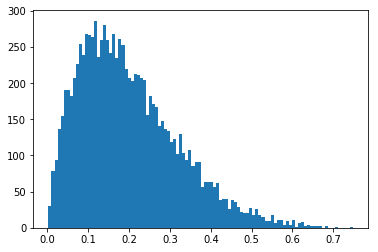

In [44]:
plt.hist(np.random.beta(2,8, 10000), bins=100);

In [45]:
y = drdt.cumsum()[1:]

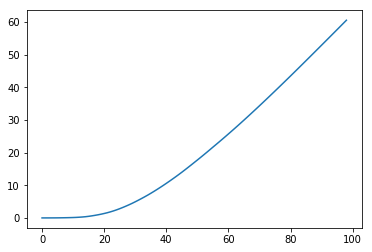

In [46]:
plt.plot(y) ## LM: I'm a python illiterate; I don't know how to make a decent plot...

In [47]:
stan_code = """ 
functions {
  real[] dr_dt(real t,
               real[] r,
               real[] theta,
               real[] x_r,
               int[] x_i) {    
    real beta = theta[1];
    real gamma = theta[2];
    real s0 = theta[3];
    real R0 = beta/gamma;
    real deriv [2];
    deriv[1] = gamma*(1-r[1]-s0*exp(-R0*r[1]));
    deriv[2] = 1;
    return deriv;
  }
}
data {
  int<lower = 0> n_obs; // Number of days sampled
  real ts[n_obs]; // Time points that were sampled
  real y_init; // initial measured population
  real y[n_obs]; // measured population at measurement times
}
transformed data{
  real xr[2] =  rep_array(0.0, 2);
  int xi[2] = rep_array(0, 2);
}
parameters {
  real<lower=0, upper=1> r_init[2]; // initial population
  real<lower=0> beta;
  real<lower=0> gamma;
  real<lower=0, upper=1> s0;
  real<lower=0> sigma;   // error scale
}
transformed parameters {
    real theta[3];   // theta = { beta, gamma, s0 }
    real  r[n_obs, 2];
    theta[1] = beta;
    theta[2] = gamma;
    theta[3] = s0;
    r = integrate_ode_rk45(dr_dt, r_init, 0, ts, theta,
                                         xr, xi,
                                         1e-6, 1e-5, 1e3);
}
model {
  beta ~ gamma(1, 1);
  gamma ~ gamma(1, 1);
  s0 ~ beta(5, 2);
  sigma ~ normal(0, 1);
  r_init ~ beta(2, 5);
  y_init ~ lognormal(log(r_init[1]), sigma);
  y ~ lognormal(log(r[, 1]), sigma);
}
generated quantities{
  real<lower=0> R0 = beta/gamma;
  real<lower=0> y_rep [n_obs];
  for (i in 1:n_obs) y_rep[i] = lognormal_rng(log(r[i, 1]), sigma);
}

"""
# make Stan model 
sm = pystan.StanModel(model_code=stan_code)
# fit = pystan.stan(model_code=stan_code, data=model_data, iter=5000, chains=3, verbose=True, n_jobs=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6bc0dbd4d6e5b5614012e39a2e73d5de NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp2hok3kqu/stanfit4anon_model_6bc0dbd4d6e5b5614012e39a2e73d5de_5908144533260290831.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [50]:
model_data = {'n_obs': y.size,
               'ts': np.arange(y.size) + 0.001,
               'y_init': 0.01,
               'y': y  
              }

In [51]:
fit = sm.sampling(data=model_data, iter=5000, chains=1, verbose=True, n_jobs=2)

In [59]:
print(fit)

Inference for Stan model: anon_model_6bc0dbd4d6e5b5614012e39a2e73d5de.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
r_init[1]   0.08  1.5e-3   0.08 4.8e-3   0.02   0.05    0.1   0.29   2594    1.0
r_init[2]   0.29  2.9e-3   0.16   0.04   0.16   0.26   0.39   0.65   3270    1.0
beta        1.14    0.02   0.92   0.25   0.52   0.82   1.44   3.75   1940    1.0
gamma       0.12  2.5e-3   0.09   0.04   0.07    0.1   0.14   0.39   1385    1.0
s0          0.75  2.9e-3   0.16   0.37   0.64   0.77   0.87   0.97   2961    1.0
sigma       2.89  3.7e-3    0.2   2.51   2.75   2.88   3.02   3.29   2819    1.0
theta[1]    1.14    0.02   0.92   0.25   0.52   0.82   1.44   3.75   1940    1.0
theta[2]    0.12  2.5e-3   0.09   0.04   0.07    0.1   0.14   0.39   1385    1.0
theta[3]    0.75  2.9e-3   0.16   0.37   0.64   0.77   0.87   0.97   2961    1.0
r

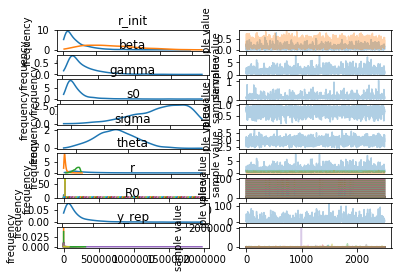

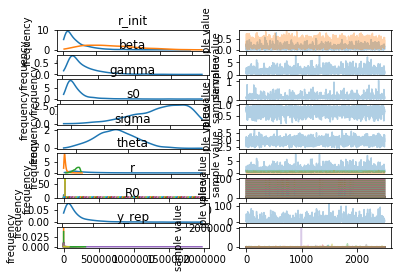

In [54]:
fit.plot() ## figure out a better plot